In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime as dt

In [695]:
df = pd.read_csv('/Users/Yifan/Downloads/task/data.csv', encoding="latin-1")

In [696]:
# check dimensions of the dataset
df.shape

(107578, 18)

In [697]:
# get only valid data df2
df1 = df[np.isfinite(df['hammer_price'])]
df2 = df1[(df1['hammer_price'] > 0)]

In [698]:
df2.shape

(90980, 18)

In [699]:
test = pd.read_csv('/Users/Yifan/Desktop/test.csv', encoding="latin-1")

In [700]:
test.shape

(16598, 18)

In [701]:
# merge test to train df2
df = pd.concat([test,df2], axis=0)

In [702]:
df.shape

(107578, 18)

In [703]:
# dummy the location variable first given test and train has different size of category

# Fill missing data with the word "Missing"
df['location'].fillna("Missing", inplace=True)
# Create dummy variables
dummies = pd.get_dummies(df['location'], prefix='location')
# Update x to include dummies and drop the original variables
df = pd.concat([df, dummies], axis=1)
df.drop(['location'], axis=1, inplace=True)


In [704]:
df.shape

(107578, 239)

In [705]:
# since auction_date share the same format, convert to numeric
def auc_date(x):
    x['auction_date'] = pd.to_datetime(x['auction_date']).apply(lambda x: x.toordinal())


auc_date(df)

In [706]:
#Before spliting dataset to test and train, clean the data first

# Fill the missing data
# Given the std of birth and death year are small and quite same, using the mean to fill NaN
# For auction_date, estimate and measurement data, since they're highly skewed, using median instead
def impute(x):
    x.loc[:,'artist_birth_year'].fillna(x.loc[:,'artist_birth_year'].mean(), inplace=True)
    x.loc[:,'artist_death_year'].fillna(x.loc[:,'artist_death_year'].mean(), inplace=True)
    
    # impute estimate price range with median
    x.loc[:,'estimate_high'].fillna(x.loc[:,'estimate_high'].median(), inplace=True)
    x.loc[:,'estimate_low'].fillna(x.loc[:,'estimate_low'].median(), inplace=True)
    x.loc[:,'measurement_depth_cm'].fillna(x.loc[:,'measurement_depth_cm'].median(), inplace=True)
    x.loc[:,'measurement_height_cm'].fillna(x.loc[:,'measurement_height_cm'].median(), inplace=True)
    x.loc[:,'measurement_width_cm'].fillna(x.loc[:,'measurement_width_cm'].median(), inplace=True)
    x.loc[:,'auction_date'].fillna(x.loc[:,'auction_date'].median(), inplace=True)
    
    
impute(df)

In [707]:
# Get new categorical, exclude location, which has already been dummies
categorical_variables2 = ['artist_name',
 'artist_nationality',
 'category',
 'currency']

In [708]:
# Get dummies for the other categorical vars
for variable in categorical_variables2:
    # Fill missing data with the word "Missing"
    df[variable].fillna("Missing", inplace=True)
        # Create dummy variables
    dummies = pd.get_dummies(df[variable], prefix=variable)
        # Update x to include dummies and drop the original variables
    df = pd.concat([df, dummies], axis=1)
    df.drop([variable], axis=1, inplace=True)

In [709]:
# For the rest categorical vars ['edition', 'materials', 'title', 'year_of_execution']
# show descritptive stats for categorical value

from IPython.display import display, HTML
def describe_cat(x):
    display(HTML(x[x.columns[x.dtypes == 'object']].describe().to_html()))

describe_cat(df)

,edition,materials,title,year_of_execution
count,13376,105739,107118,79818
unique,8445,15021,39158,1026
top,unique,Works on Paper,Untitled,1969
freq,179,20346,12450,2113


In [710]:
# Given the number of unique category are too large, dropping out these four vars
df = df.drop(['edition', 'materials', 'title', 'year_of_execution'], axis=1)

## Split test and train

In [711]:
# extract test data with new created dummies location
l = len(test)
test2 = df.iloc[:l,]
train = df.iloc[l:,]

In [712]:
# get train x and train y from train dataset
y_train = np.log(train.pop('hammer_price'))
x_train = train

In [683]:
# get test x and test y from test dataset
y_test = np.log(test2.pop('hammer_price'))
x_test = test2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [ ]:
# Fit Random Forest Model
RFmodel = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, min_samples_leaf=1, random_state=42)
RFmodel.fit(x_train,y_train)

In [ ]:
# Predict y by x_test with RF model
# print output for y_train as predicted price of each row in test dataset
y_predicted = RFmodel.predict(x_test)
output = pd.DataFrame(y_predicted, columns = ['y_train'])

In [ ]:
# get RMSE for RF model 
RMSE = sqrt(mean_squared_error(y_test, y_predicted))
print(RMSE)

## My trial

In [753]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

df = pd.read_csv('/Users/Yifan/Downloads/task/data.csv', encoding="latin-1")
# drop missing and negative(-1) hammer_price row from data frame df
df1 = df[np.isfinite(df['hammer_price'])]
df2 = df1[(df1['hammer_price'] > 0)]

In [756]:
y = np.log(df2['hammer_price'])
x = df2.drop('hammer_price', axis=1)

In [758]:
# show descritptive stats for categorical value
from IPython.display import display, HTML
def describe_cat(x):
    display(HTML(x[x.columns[x.dtypes == 'object']].describe().to_html()))

describe_cat(x)

,artist_name,artist_nationality,auction_date,category,currency,edition,location,materials,title,year_of_execution
count,90980,90980,90980,90980,90980,7688,79419,89972,90935,65895
unique,119,17,4533,15,3,5064,208,8295,29915,642
top,Henry Moore,American,1995-03-22T01:00:00.000Z,Painting,USD,unique,New York,Works on Paper,Untitled,1969
freq,4874,37909,1234,22203,53555,32,41128,20334,10839,1799


In [759]:
# Drop out large unique category number variables
x = x.drop(['edition', 'materials', 'title', 'year_of_execution'], axis=1)

In [761]:
# since auction_date share the same format, convert to numeric
def auc_date(x):
    x['auction_date'] = pd.to_datetime(x['auction_date']).apply(lambda x: x.toordinal())

auc_date(x)

In [763]:
# Only consider not large unique category number var for dummies
categorical_variables = ['artist_name',
 'artist_nationality',
 'category',
 'currency', 'location']

In [730]:
# Check unequal category size among these five cat vars
new_catg=[]
for i in categorical_variables:
    dummy1=pd.get_dummies(df2[i]).shape[1]
    dummy2=pd.get_dummies(test[i]).shape[1]
    if dummy1==dummy2:
        new_catg.append(i)

In [731]:
new_catg

['artist_name', 'artist_nationality', 'category', 'currency']

unequal var = location
get the test data with location dummies

In [765]:
# impute artist_death_year, estimate_high, estimate_low with mean
def impute(x):
    x.loc[:,'artist_death_year'].fillna(x.loc[:,'artist_death_year'].mean(), inplace=True)
    # impute estimate price range with median
    x.loc[:,'estimate_high'].fillna(x.loc[:,'estimate_high'].median(), inplace=True)
    x.loc[:,'estimate_low'].fillna(x.loc[:,'estimate_low'].median(), inplace=True)

impute(x)

In [766]:
# Fill the missing value with mean and median
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    x[variable].fillna("Missing", inplace=True)
        # Create dummy variables
    dummies = pd.get_dummies(x[variable], prefix=variable)
        # Update x to include dummies and drop the original variables
    x = pd.concat([x, dummies], axis=1)
    x.drop([variable], axis=1, inplace=True)

In [767]:
# To save running time, only take in 50 estimators
model = RandomForestRegressor(50, oob_score=True, n_jobs=-1, min_samples_leaf=1, random_state=42,)
model.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [768]:
# get RMSE for RF model 
RMSE3 = sqrt(mean_squared_error(y, model2.oob_prediction_))
print(RMSE3)

0.5600256068851456


# Feature Importance

In [770]:
# viz all variables
feature_importances = pd.Series(model.feature_importances_, index=x.columns)

In [771]:
feature_importances.sort_values(ascending=False)[:20]

estimate_high                    0.440579
estimate_low                     0.129804
auction_date                     0.101689
measurement_height_cm            0.082969
measurement_width_cm             0.047334
location_New York                0.037681
artist_birth_year                0.026534
location_London                  0.021039
artist_death_year                0.013453
currency_GBP                     0.008194
artist_nationality_American      0.006227
artist_name_Andre Derain         0.005877
artist_name_Man Ray              0.005135
measurement_depth_cm             0.004682
location_Missing                 0.003960
artist_nationality_British       0.002953
artist_name_Willem de Kooning    0.002206
artist_name_Henry Moore          0.002045
artist_nationality_French        0.001931
artist_name_Louise Nevelson      0.001899
dtype: float64

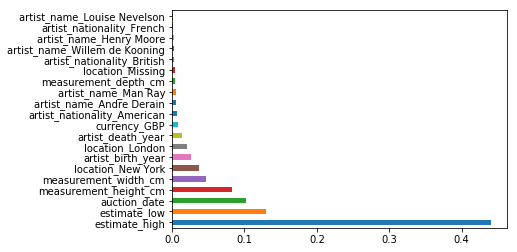

In [772]:
# Since has 371 features, only plot first 20 important features
feature_importances.sort_values(ascending=False)[:20].plot(kind='barh')
plt.show()

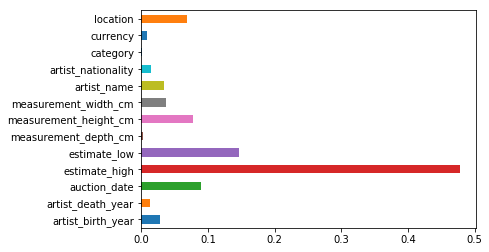

In [773]:
# Since dummies spreading all categorical variables, need to 
# function for showing the summary

def summary_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    # True autoscale would automatically adjust the x size to the largest feature + headroom
    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1
        
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    # The list of column prefixes to summarize on
    if summarized_columns:
        for col_name in summarized_columns:
            # sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            # remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            # finally, get the summarized field
            feature_dict[col_name] = sum_value
            
    results = pd.Series(list(feature_dict.values()), index=feature_dict.keys())
    results.sort_values()
    results.plot(kind="barh")

summary_feature_importances(model2, x_model2.columns, summarized_columns = categorical_variables)
plt.show()

# Parameter tests

In [308]:
# Before consider taking in the dropped-out categorical variables
# test the parameters to train the model better

In [315]:
### n_estimators

results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model2 = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model2.fit(x_model2, y)
    print (trees, "trees")
    RMSE = sqrt(mean_squared_error(y, model2.oob_prediction_))
    print ("RMSE", RMSE)
    results.append(RMSE)
    print ("")
    
pd.Series(results, n_estimator_options).plot()

30 trees
RMSE 0.4242792332541968

50 trees
RMSE 0.41399065032426025

100 trees
RMSE 0.40700588124295356

200 trees
RMSE 0.40336296491393636

500 trees
RMSE 0.4013058126656349

1000 trees
RMSE 0.40045780838613515

2000 trees
RMSE 0.40013949846612795



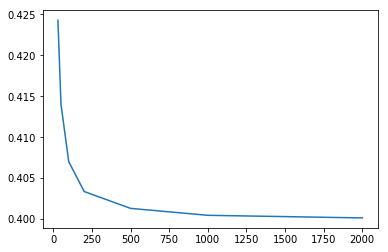

In [316]:
plt.show()

# Output for n_estimators
30 trees
RMSE 0.4242792332541968

50 trees
RMSE 0.41399065032426025

100 trees
RMSE 0.40700588124295356

200 trees
RMSE 0.40336296491393636

500 trees
RMSE 0.4013058126656349

1000 trees
RMSE 0.40045780838613515

2000 trees
RMSE 0.40013949846612795

In [319]:
### max_features: number of features take into the model
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model2 = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model2.fit(x_model2, y)
    print (max_features, "features")
    RMSE = sqrt(mean_squared_error(y, model2.oob_prediction_))
    print ("RMSE: ", RMSE)
    results.append(RMSE)
    print ("")
    
pd.Series(results, max_features_options).plot(kind="barh")

auto features
RMSE:  0.40045780838613515

None features
RMSE:  0.40045780838613515

sqrt features
RMSE:  0.5934767324237529

log2 features
RMSE:  0.6265172991860208

0.9 features
RMSE:  0.4007869635753079

0.2 features
RMSE:  0.4901372231226885



# Output for max_features
auto features
RMSE:  0.40045780838613515

None features
RMSE:  0.40045780838613515

sqrt features
RMSE:  0.5934767324237529

log2 features
RMSE:  0.6265172991860208

0.9 features
RMSE:  0.4007869635753079

0.2 features
RMSE:  0.4901372231226885

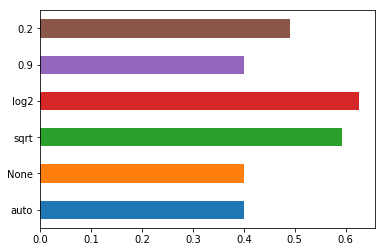

In [320]:
plt.show()

In [322]:
### min_samples_leaf
results = []
min_samples_leaf_options = [1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model2 = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42, max_features='auto', min_samples_leaf=min_samples)
    model2.fit(x_model2, y)
    print (min_samples, "min_samples")
    RMSE = sqrt(mean_squared_error(y, model2.oob_prediction_))
    print ("RMSE: ", RMSE)
    results.append(RMSE)
    print ("")
    
pd.Series(results, min_samples_leaf_options).plot()

1 min_samples
RMSE:  0.40045780838613515

2 min_samples
RMSE:  0.4231435772780872

3 min_samples
RMSE:  0.445645520354724

4 min_samples
RMSE:  0.4681936943681546

5 min_samples
RMSE:  0.4884725948008925

6 min_samples
RMSE:  0.5063083571221659

7 min_samples
RMSE:  0.5219843677797569

8 min_samples
RMSE:  0.5360532301543444

9 min_samples
RMSE:  0.5486828723306593

10 min_samples
RMSE:  0.5600256068851456



# Output for min_samples_leaf
1 min_samples
RMSE:  0.40045780838613515

2 min_samples
RMSE:  0.4231435772780872

3 min_samples
RMSE:  0.445645520354724

4 min_samples
RMSE:  0.4681936943681546

5 min_samples
RMSE:  0.4884725948008925

6 min_samples
RMSE:  0.5063083571221659

7 min_samples
RMSE:  0.5219843677797569

8 min_samples
RMSE:  0.5360532301543444

9 min_samples
RMSE:  0.5486828723306593

10 min_samples
RMSE:  0.5600256068851456

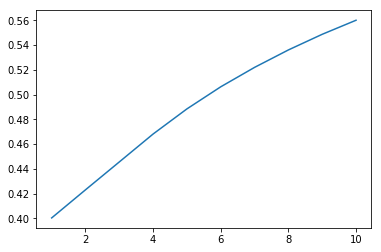

In [323]:
plt.show()

plug in all optimized parameters to RF model3

In [325]:
model_opt = RandomForestRegressor(n_estimators=1000, 
                               oob_score=True, 
                               n_jobs=-1, 
                               random_state=42, 
                               max_features='auto', 
                               min_samples_leaf=1)
model_opt.fit(x, y)
RMSE = sqrt(mean_squared_error(y, model_opt.oob_prediction_))
print ("RMSE: ", RMSE)

RMSE:  0.40045780838613515


Improved !!

# EDA

In [39]:
#skewness and kurtosis for hammer_price
print("Skewness: %f" % df2['hammer_price'].skew())
print("Kurtosis: %f" % df2['hammer_price'].kurt())

Skewness: 59.378420
Kurtosis: 6158.048880


In [ ]:
# viz hammer_price, highly skewed, then take log transformation
y = np.log(y)

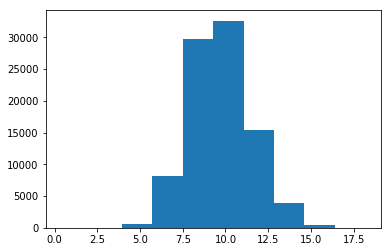

In [229]:
plt.hist(y)
plt.show()

In [93]:
# calculate missing data ratio after dropping the NaN and negative hamemr_price
df3 = df
df3_na = (df3.isnull().sum() / len(df3)) * 100
df3_na = df3_na.drop(df3_na[df3_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :df3_na})
missing_data

,Missing Ratio
edition,91.549791
estimate_high,42.702792
estimate_low,42.700594
artist_death_year,30.023082
year_of_execution,27.571994
location,12.707188
materials,1.107936
title,0.049461


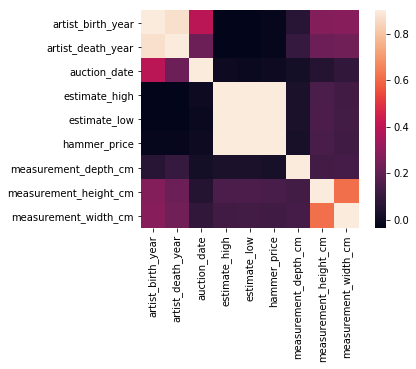

In [150]:
# check the correlation matrix to see how numeric variables are related to target

corrmat = df2.corr()
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()